In [1]:
import gym, os
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Multinomial
import torchvision.transforms as T
from wrappers import *

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("PongNoFrameskip-v4")
env = make_env(env)

state_space = env.observation_space.shape[0]
print(env.observation_space.shape)
action_space = env.action_space.n
print(action_space)

print(device)

(84, 84, 4)
6
cpu


Helper function

In [2]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 3000

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def get_screen(x):
    state = np.array(x)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = state.float() / 255
    return state.unsqueeze(0)

def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))

def game_initializer(module):
    """ Parameter initializer for Atari models
    Initializes Linear, Conv2d, and LSTM weights.
    """
    classname = module.__class__.__name__

    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'Conv2d':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'LSTM':
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'weight_hh' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'bias' in name:
                param.data.zero_()

Creating two seperate networks the actor and the critic

In [5]:
end_out = 64


class ActorCritic(nn.Module):
    def __init__(self, num_frames, h, w, outputs):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, end_out, kernel_size=3, stride=1)
        
        self.down = nn.Linear(7*7*64, 512)
        self.a = nn.Linear(512, outputs)
        self.c = nn.Linear(512, 1)
        
        self.apply(game_initializer)
        self.a.weight.data = ortho_weights(self.a.weight.size(), scale=.01)
        self.c.weight.data = ortho_weights(self.c.weight.size())

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.down(x.view(x.size(0), -1))
        a = self.a(x)
        c = self.c(x)
        a = Categorical(logits=a)
        return a, c

In [7]:
learn_rate = 1e-4
n_iters = 5000
avg_over = 1
val_loss_coeff = 0.5
ent_loss_coeff = 0.01

init_screen = get_screen(env.reset())
_, num_frames, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

actor_critic = ActorCritic(num_frames, screen_height, screen_width, n_actions).to(device)
#critic = Critic(num_frames, screen_height, screen_width, n_actions).to(device)

optimizer = optim.Adam(actor_critic.parameters(), lr=learn_rate)
#optimizerC = optim.Adam(critic.parameters(), lr=learn_rate)

score_avg = []
ac_loss_list = []


for iter in range(n_iters):
    state = get_screen(env.reset())
    log_probs = []
    steps = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    reward_sum = 0

    for i in count():
        #env.render()
        #state = torch.FloatTensor(state).to(device)
        dist, value = actor_critic(state)
        
        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = get_screen(next_state)
        
        reward_sum += reward
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state
        if done:
            #print('Iteration: {}, Score: {}'.format(iter, i))
            score_avg.append(reward_sum)
            reward_sum=0
            break
    
        
    
    #next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = actor_critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values
    
    actor_loss = -(log_probs * advantage.detach()).mean()
    #print(actor_loss)
    critic_loss = val_loss_coeff * (advantage.pow(2)).mean()
    #print(critic_loss)
    ent_loss = ent_loss_coeff*entropy
    #print(ent_loss)

    ac_loss = actor_loss + critic_loss
    print('Iteration: {}, Score avg: {}, Loss: {}, A: {}, C: {}'.format(iter, score_avg[iter], ac_loss, actor_loss, critic_loss))
    
    
    ac_loss_list.append(ac_loss)

    #optimizer.zero_grad()
    ac_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Iteration: 0, Score avg: -2.0, Loss: -1.3677687644958496, A: -2.1377103328704834, C: 0.769941508769989
Iteration: 1, Score avg: -19.0, Loss: 0.1818438172340393, A: -0.18073052167892456, C: 0.36257433891296387
Iteration: 2, Score avg: -21.0, Loss: 1.4682503938674927, A: 1.1113126277923584, C: 0.35693779587745667
Iteration: 3, Score avg: -21.0, Loss: 3.117833137512207, A: 2.2233402729034424, C: 0.8944929838180542
Iteration: 4, Score avg: -20.0, Loss: 2.1922993659973145, A: 1.5268547534942627, C: 0.6654447317123413
Iteration: 5, Score avg: -21.0, Loss: -0.5614846348762512, A: -0.8077113032341003, C: 0.24622668325901031
Iteration: 6, Score avg: -21.0, Loss: -0.5885114669799805, A: -0.9272263050079346, C: 0.3387148678302765
Iteration: 7, Score avg: -20.0, Loss: -0.8150244951248169, A: -1.321501612663269, C: 0.5064771175384521
Iteration: 8, Score avg: -18.0, Loss: 0.2517157196998596, A: -0.1873418241739273, C: 0.43905752897262573
Iteration: 9, Score avg: -21.0, Loss: -0.8635362386703491, A: 

Iteration: 78, Score avg: -19.0, Loss: 1.7913188934326172, A: 1.14185631275177, C: 0.6494625806808472
Iteration: 79, Score avg: -18.0, Loss: 2.6316046714782715, A: 1.71030855178833, C: 0.9212961792945862
Iteration: 80, Score avg: -20.0, Loss: 1.3890588283538818, A: 0.975968599319458, C: 0.41309016942977905
Iteration: 81, Score avg: -20.0, Loss: -0.06395348906517029, A: -0.42532944679260254, C: 0.36137595772743225
Iteration: 82, Score avg: -20.0, Loss: -0.08658012747764587, A: -0.4512020945549011, C: 0.36462196707725525
Iteration: 83, Score avg: -21.0, Loss: -0.5375293493270874, A: -0.8745530843734741, C: 0.33702370524406433
Iteration: 84, Score avg: -21.0, Loss: -0.941603422164917, A: -1.4505425691604614, C: 0.5089391469955444
Iteration: 85, Score avg: -20.0, Loss: 0.2148270308971405, A: -0.011326386593282223, C: 0.2261534184217453
Iteration: 86, Score avg: -21.0, Loss: -0.6157519221305847, A: -0.8991208076477051, C: 0.28336888551712036
Iteration: 87, Score avg: -21.0, Loss: -0.3875866

Iteration: 155, Score avg: -21.0, Loss: 0.49346691370010376, A: 0.26630550622940063, C: 0.22716140747070312
Iteration: 156, Score avg: -20.0, Loss: 0.8127446174621582, A: 0.5224906802177429, C: 0.2902539074420929
Iteration: 157, Score avg: -21.0, Loss: 0.2058420330286026, A: 0.019282888621091843, C: 0.18655914068222046
Iteration: 158, Score avg: -21.0, Loss: 0.27149587869644165, A: 0.11296717077493668, C: 0.15852870047092438
Iteration: 159, Score avg: -20.0, Loss: 1.2139945030212402, A: 0.8041645288467407, C: 0.4098299741744995
Iteration: 160, Score avg: -21.0, Loss: 0.5567993521690369, A: 0.2419985681772232, C: 0.31480079889297485
Iteration: 161, Score avg: -21.0, Loss: 0.3373417258262634, A: 0.17745019495487213, C: 0.1598915308713913


KeyboardInterrupt: 

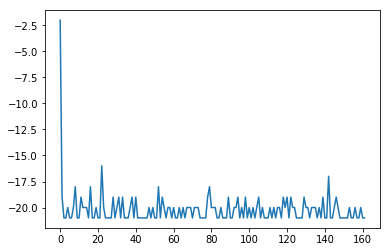

In [8]:
plt.plot(score_avg)

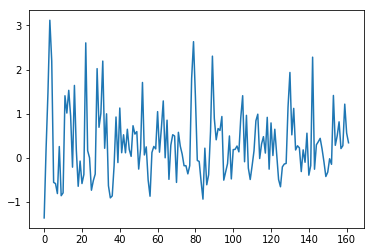

In [9]:
plt.plot(ac_loss_list)

In [ ]:
n_iter = 5
for iter in range(n_iter):
    state = get_screen(env.reset())
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    reward_sum = 0

    for i in count():
        env.render()
        #state = torch.FloatTensor(state).to(device)
        dist, value = actor_critic(state)
        
        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = get_screen(next_state)
        
        reward_sum += reward
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state
        if done:
            break
env.close()

In [ ]:
torch.save(actor, 'results/actor.pkl')
torch.save(critic, 'results/critic.pkl')
env.close()